# Bilibili 每周必看排行榜

## 1950083 自动化 刘智宇

## 01 导入必要的包

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import csv
import os

import re  # 导入正则表达式

import requests
from bs4 import BeautifulSoup

import time

import jieba.analyse
import wordcloud
from PIL import Image



# 为了在Jupyter Notebook中显示图片的必须配置项
%matplotlib inline
# 用兼容字体解决中文显示为方格的问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.serif'] = ['SimHei']
plt.rcParams['font.family'] = 'sans-serif'
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

## 02 常量定义 & 全局变量定义

In [4]:
# 常量定义
# 排行榜URL
# 没有具体指定排行榜期数，会跳转到最新的排行榜
RankBoardJsonRequestUrlPrefix = 'https://api.bilibili.com/x/web-interface/popular/series/one?number='
LatestRankBoardID = 167  # biblibili排行榜最新期数

# 浏览器请求头
RequestHeader = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.54 Safari/537.36"}
# 文件存储路径
RankBoardsDatabasePath = r'Databases\rankboards.csv'
UsersDatabasePath = r'Databases\users.csv'
VideosDatabasePath = r'Databases\videos.csv'

SeparateBar = "--------------------------------------------------"

# 全局变量定义
# VideoList = []
# UserList = []
# BoardList = []


## 03 类定义

In [3]:
# B站视频类
class VideoClass():
    def __init__(self, videoUrl):
        self.videoBVID = None
        self.videoCID = 0
        self.videoName = None
        self.videoOwnerID = 0
        self.videoUrl = videoUrl
        self.videoViews = 0
        self.videoDanmaku = 0
        self.videoLength = 0
        self.videoLikes = 0
        self.videoCoins = 0
        self.videoFavorites = 0
        self.videoComments = 0
        self.videoShares = 0
        self.videoRecommendReason = None
        self.videoTag = None
        self.videoReleaseTimeStamp = 0
        self.videoBoardID = 0
        self.videoBoardRank = 0

    def showVideoInfo(self):
        print("videoBVID            : ",self.videoBVID)
        print("videoCID             : ",self.videoCID)
        print("videoName            : ",self.videoName)
        print("videoOwnerID         : ",self.videoOwnerID)
        print("videoUrl             : ",self.videoUrl)
        print("videoViews           : ",self.videoViews)
        print("videoDanmaku         : ",self.videoDanmaku)
        print("videoLength          : ",self.videoLength)
        print("videoLikes           : ",self.videoLikes)
        print("videoCoins           : ",self.videoCoins)
        print("videoFavorites       : ",self.videoFavorites)
        print("videoComments        : ",self.videoComments)
        print("videoShares          : ",self.videoShares)
        print("videoRecommendReason : ",self.videoRecommendReason)
        print("videoTag             : ",self.videoTag)
        print("videoReleaseTimeStamp: ",self.videoReleaseTimeStamp)
        print("videoBoardID         : ",self.videoBoardID)
        print("videoBoardRank       : ",self.videoBoardRank)
    
    # 在获取完BVID和CID后可以获取视频长度
    def initVideoLength(self):
        videoPlayUrlPrefix = 'https://api.bilibili.com/x/player/playurl?cid='
        videoPlayUrlMidfix = '&bvid='
        fullVideoPlayJsonRequestUrl = videoPlayUrlPrefix + str(self.videoCID) + videoPlayUrlMidfix + str(self.videoBVID)
        videoPlayJson = requests.get(url=fullVideoPlayJsonRequestUrl, headers=RequestHeader).json()
        self.videoLength = videoPlayJson['data']['timelength']

    # 从排行榜进行初始化
    def initVideoInfoFromBoard(self, videoBoardRank, boardJson, boardID):
        self.videoBoardRank = videoBoardRank + 1
        self.videoBVID = boardJson['data']['list'][videoBoardRank]['bvid']
        self.videoCID = boardJson['data']['list'][videoBoardRank]['cid']
        self.videoName = boardJson['data']['list'][videoBoardRank]['title']
        self.videoOwnerID = boardJson['data']['list'][videoBoardRank]['owner']['mid']
        self.videoViews = boardJson['data']['list'][videoBoardRank]['stat']['view']
        self.videoDanmaku = boardJson['data']['list'][videoBoardRank]['stat']['danmaku']
        self.videoReleaseTimeStamp = boardJson['data']['list'][videoBoardRank]['ctime']
        self.videoBoardID = boardID
        self.videoLikes = boardJson['data']['list'][videoBoardRank]['stat']['like']
        self.videoCoins = boardJson['data']['list'][videoBoardRank]['stat']['coin']
        self.videoFavorites = boardJson['data']['list'][videoBoardRank]['stat']['favorite']
        self.videoComments = boardJson['data']['list'][videoBoardRank]['stat']['reply']
        self.videoShares = boardJson['data']['list'][videoBoardRank]['stat']['share']
        self.videoRecommendReason = boardJson['data']['list'][videoBoardRank]['rcmd_reason']
        self.videoTag = boardJson['data']['list'][videoBoardRank]['tname']
        
    def initAllVideoInfo(self, videoBoardRank, boardJson, boardID):
        self.initVideoInfoFromBoard(videoBoardRank, boardJson, boardID)
        self.initVideoLength()
        self.saveOneselfToDatabase(databasePath=VideosDatabasePath)
        
    def saveOneselfToDatabase(self, databasePath):
        # write + text
        with open(file=databasePath, mode='a', encoding="utf-8", newline="") as databaseFile:
            databaseWriter = csv.writer(databaseFile)
            # 判断文件十分为空，为空则添加header
            if os.path.getsize(databasePath) == 0:
                print(databasePath, "is Empty. Do initialization.")
                databaseWriter.writerow(["videoBVID", "videoName", "videoOwnerID", "videoViews", "videoDanmaku", "videoLength", \
                                        "videoLikes", "videoCoins", "videoFavorites", "videoComments", "videoShares", \
                                        "videoRecommendReason", "videoTag", "videoReleaseTimeStamp", "videoBoardID" ,"videoBoardRank"])
            else:
                # print(databasePath, "is Not Empty.")
                pass

            # 将信息写入database中
            databaseWriter.writerow([self.videoBVID, self.videoName, self.videoOwnerID, self.videoViews, self.videoDanmaku, self.videoLength, \
                                    self.videoLikes, self.videoCoins, self.videoFavorites, self.videoComments, self.videoShares, \
                                    self.videoRecommendReason, self.videoTag, self.videoReleaseTimeStamp, self.videoBoardID ,self.videoBoardRank])
            
 

In [52]:
# B站用户类
class UserClass():
    # UserList = []
    def __init__(self, userVideoUrl):
        self.userID = 0
        self.userName = None
        # self.userVideoUrl = userVideoUrl
        # self.userMainPageUrl = None
        self.userFollows = 0
        self.userFans = 0
        self.userVideos = 0
        
    def showUserInfo(self):
        print("userID           : ",self.userID)
        print("userName         : ",self.userName)
        # print("userVideoUrl     : ",self.userVideoUrl)
        # print("userMainPageUrl  : ",self.userMainPageUrl)
        print("userFollows      : ",self.userFollows)
        print("userFans         : ",self.userFans)
        print("userVideos       : ",self.userVideos)
        

    def initAllUserInfo(self, videoBoardRank, boardJson):
        self.initPartUserInfoFromBoard(videoBoardRank, boardJson)
        self.initOtherUserInfo()
        # UserClass.UserList.append(self)
        # self.showUserInfo()
        self.saveOneselfToDatabase(databasePath=UsersDatabasePath)

    def initPartUserInfoFromBoard(self, videoBoardRank, boardJson):
        self.userID = boardJson['data']['list'][videoBoardRank]['owner']['mid']
        self.userName = boardJson['data']['list'][videoBoardRank]['owner']['name']
    
    def initOtherUserInfo(self):
        # userVideoResponse = requests.get(self.userVideoUrl, headers=RequestHeader)
        # print("video page status code   : ", userVideoResponse.status_code)
        # userVideoSoup = BeautifulSoup(userVideoResponse.text, 'html.parser')

        # # 有可能无法通过该方法获取用户主页信息，故添加特殊处理
        # # 后续找到原因是联合投稿的视频与单人创作的网页格式不同
        # up_info_right = userVideoSoup.find('div', {'class':'up-info_right'})
        # if up_info_right is None:
        #     print("Can't get", self.userName, "'s MainPage url.")
        # else:
        #     self.userMainPageUrl = 'https:' + up_info_right.find('a').get('href')
        #     # print('userMainPageUrl          : ', self.userMainPageUrl)

        commonFollowFanRequestUrlPrefix = 'https://api.bilibili.com/x/relation/stat?vmid='
        commonFollowFanRequestUrlSuffix = '&jsonp=jsonp'
        fullFollowFanRequestUrl = commonFollowFanRequestUrlPrefix + str(self.userID) + commonFollowFanRequestUrlSuffix
        followFanJson =  requests.get(fullFollowFanRequestUrl, headers=RequestHeader).json()
        self.userFollows = followFanJson['data']['following']
        self.userFans = followFanJson['data']['follower']
        # commonFollowFanRequestUrlPrefix = 'https://api.bilibili.com/x/relation/stat?vmid='
        # commonFollowFanRequestUrlSuffix = '&jsonp=jsonp'
        commonUserWorkAmountRequestUrlPrefix = 'https://api.bilibili.com/x/space/navnum?mid='
        fullUserWorkAmountRequestUrl = commonUserWorkAmountRequestUrlPrefix + str(self.userID)
        userWorkAmountJson = requests.get(fullUserWorkAmountRequestUrl, headers=RequestHeader).json()
        self.userVideos = userWorkAmountJson['data']['video']

    def saveOneselfToDatabase(self, databasePath):
        with open(file=databasePath, mode='a', encoding="utf-8", newline="") as databaseFile:
            databaseWriter = csv.writer(databaseFile)
            # 判断文件十分为空，为空则添加header
            if os.path.getsize(databasePath) == 0:
                print(databasePath, "is Empty. Do initialization.")
                databaseWriter.writerow(["userID", "userName", "userFollows", "userFans", "userVideos"])
            else:
                # print(databasePath, "is Not Empty.")
                pass

            # 将信息写入database中
            databaseWriter.writerow([self.userID, self.userName, self.userFollows, self.userFans, self.userVideos])
            


In [53]:
# B站排行榜类
class RankBoardClass():
    def __init__(self, boardJsonRequestUrl):
        self.boardJson = None
        self.boardID = None
        self.boardName = ""
        self.boardSubject = ""
        self.boardJsonRequestUrl = boardJsonRequestUrl
        self.boardEndTimeStamp = None
        self.boardLength = 0
        self.boardVideosAverageViews = 0.0
        self.boardVideosList = []
    
    def showBoardInfo(self):
        print("boardID                  : ",self.boardID)
        print("boardName                : ",self.boardName)
        print("boardSubject             : ",self.boardSubject)
        print("boardJsonRequestUrl      : ",self.boardJsonRequestUrl)
        print("boardEndTimeStamp        : ",self.boardEndTimeStamp)
        print("boardLength              : ",self.boardLength)
        print("boardVideosAverageViews  : ",self.boardVideosAverageViews)
        for idx in range(self.boardLength):
            print("boardVideosUrl[%3d]  : "%idx,self.boardVideosList[idx].videoName)
        
    # 初始化排行榜信息
    def initBoardInfo(self):
        self.boardJson = requests.get(url=self.boardJsonRequestUrl,headers=RequestHeader).json()
        self.boardID = self.boardJson['data']['config']['number']
        self.boardName = self.boardJson['data']['config']['name']
        self.boardSubject = self.boardJson['data']['config']['subject']
        self.boardLength = len(self.boardJson['data']['list'])
        self.boardEndTimeStamp = self.boardJson['data']['config']['etime']
        self.addAllVideoToBoardList()
        self.addAllUsers()
        self.computeBoardVideosAverageViews()
        self.saveOneselfToDatabase(databasePath=RankBoardsDatabasePath)

    def addOneVideoToBoardList(self, videoRank):
        tempVideo = VideoClass(videoUrl=self.boardJson['data']['list'][videoRank]['short_link'])
        tempVideo.initAllVideoInfo(videoRank,self.boardJson,self.boardID)
        self.boardVideosList.append(tempVideo)
    
    # 获取视频列表
    def addAllVideoToBoardList(self):
        for videoRank in range(self.boardLength):
            self.addOneVideoToBoardList(videoRank)

    def computeBoardVideosAverageViews(self):
        sumViews = 0.0  # 总播放量
        for video in self.boardVideosList:
            sumViews += video.videoViews
        self.boardVideosAverageViews = sumViews/self.boardLength

    # 处理用户信息
    def addOneUser(self, videoRank):
        tempUser = UserClass(userVideoUrl=self.boardJson['data']['list'][videoRank]['short_link'])
        tempUser.initAllUserInfo(videoRank, self.boardJson)

    def addAllUsers(self):
        for videoRank in range(self.boardLength):
            self.addOneUser(videoRank)

    def saveOneselfToDatabase(self, databasePath):
        # write + text
        with open(file=databasePath, mode='a', encoding="utf-8", newline="\n") as databaseFile:
            databaseWriter = csv.writer(databaseFile)
            # 判断文件十分为空，为空则添加header
            if os.path.getsize(databasePath) == 0:
                print(databasePath, "is Empty. Do initialization.")
                databaseWriter.writerow(["boardID", "boardName", "boardSubject", "boardJsonRequestUrl", \
                                        "boardEndTimeStamp", "boardLength", "boardVideosAverageViews"])
            else:
                # print(databasePath, "is Not Empty.")
                pass

            # 将信息写入database中
            databaseWriter.writerow([self.boardID, self.boardName, self.boardSubject, self.boardJsonRequestUrl, \
                                    self.boardEndTimeStamp, self.boardLength, self.boardVideosAverageViews])

## 04 获取全部信息

In [54]:
def getOneRankBoardAllInfo(boardID):
    print(SeparateBar)
    print("获取第%3d期排行榜数据信息"%(boardID))
    startTime = time.time()
    fullBoardJsonRequestUrl = RankBoardJsonRequestUrlPrefix + str(boardID)
    tempRankBoard = RankBoardClass(boardJsonRequestUrl=fullBoardJsonRequestUrl)
    tempRankBoard.initBoardInfo()  # Init的时候自动将信息存入
    print("RankBoardName    :", tempRankBoard.boardName)
    print("RankBoardLEngth  :", tempRankBoard.boardLength)
    endTime = time.time()
    spendTime = endTime-startTime
    print("获取第%3d排行榜数据信息，耗时%.3f秒"%(boardID, spendTime))
    print(SeparateBar)
    return tempRankBoard

In [55]:
StartRankBoardID = 167
EndRankBoardID = 117
BoardIDList = [id for id in range(StartRankBoardID, EndRankBoardID, -1)]  
# 从start到end，大包括，小不包括
# print(len(BoardIDList))

# 倒序获取
for boardID in BoardIDList:
    getOneRankBoardAllInfo(boardID=boardID)
    time.sleep(10)  # 让服务器休息一会
# getOneRankBoardAllInfo(boardID=1)

--------------------------------------------------
获取第117期排行榜数据信息
RankBoardName    : 2021第117期 06.11 - 06.17
RankBoardLEngth  : 37
获取第117排行榜数据信息，耗时13.802秒
--------------------------------------------------


## 05 读取数据集

In [5]:
rankBoardsDatabaseDF = pd.read_csv(filepath_or_buffer=RankBoardsDatabasePath, header=0, index_col=None)
usersDatabaseDF = pd.read_csv(filepath_or_buffer=UsersDatabasePath, header=0, index_col=None)
videosDatabaseDF = pd.read_csv(filepath_or_buffer=VideosDatabasePath, header=0, index_col=None)

In [5]:
print("rankBoardsDatabaseDF\n", rankBoardsDatabaseDF.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   boardID                  50 non-null     int64  
 1   boardName                50 non-null     object 
 2   boardSubject             50 non-null     object 
 3   boardJsonRequestUrl      50 non-null     object 
 4   boardEndTimeStamp        50 non-null     int64  
 5   boardLength              50 non-null     int64  
 6   boardVideosAverageViews  50 non-null     float64
dtypes: float64(1), int64(3), object(3)
memory usage: 2.9+ KB
rankBoardsDatabaseDF
 None


In [6]:
print("usersDatabaseDF\n", usersDatabaseDF.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2093 entries, 0 to 2092
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   userID       2093 non-null   int64 
 1   userName     2093 non-null   object
 2   userFollows  2093 non-null   int64 
 3   userFans     2093 non-null   int64 
 4   userVideos   2093 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 81.9+ KB
usersDatabaseDF
 None


In [7]:
print("videosDatabaseDF\n", videosDatabaseDF.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2093 entries, 0 to 2092
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   videoBVID              2093 non-null   object
 1   videoName              2093 non-null   object
 2   videoOwnerID           2093 non-null   int64 
 3   videoViews             2093 non-null   int64 
 4   videoDanmaku           2093 non-null   int64 
 5   videoLength            2093 non-null   int64 
 6   videoLikes             2093 non-null   int64 
 7   videoCoins             2093 non-null   int64 
 8   videoFavorites         2093 non-null   int64 
 9   videoComments          2093 non-null   int64 
 10  videoShares            2093 non-null   int64 
 11  videoRecommendReason   2092 non-null   object
 12  videoTag               2093 non-null   object
 13  videoReleaseTimeStamp  2093 non-null   int64 
 14  videoBoardID           2093 non-null   int64 
 15  videoBoardRank       

## 06 数据可视化

### 排行榜分析

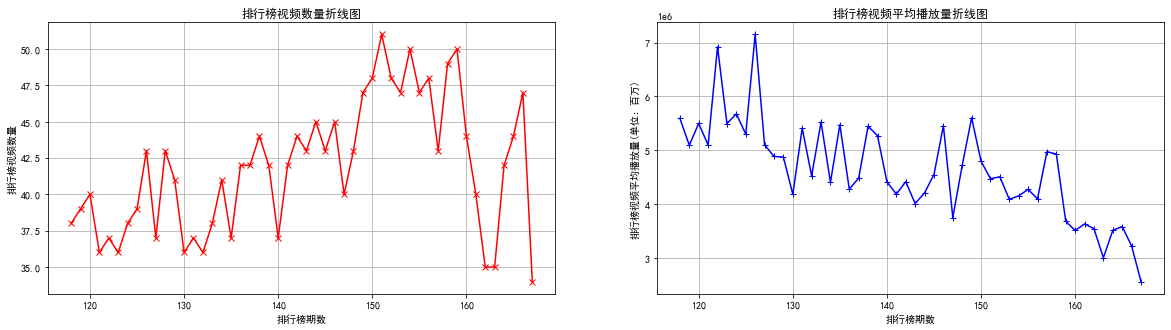

In [6]:
BoardIDs = rankBoardsDatabaseDF.loc[:, 'boardID']  # 排行榜期数
BoardLengths = rankBoardsDatabaseDF.loc[:, 'boardLength']  # 排行榜长度
BoardAverageViews = rankBoardsDatabaseDF.loc[:, 'boardVideosAverageViews']

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title("排行榜视频数量折线图")
plt.xlabel("排行榜期数")
plt.ylabel("排行榜视频数量")
plt.grid()
plt.plot(BoardIDs, BoardLengths, linestyle='-', color='red', marker='x', linewidth=1.5) # 设置颜色及透明度


plt.subplot(1, 2, 2)
plt.title("排行榜视频平均播放量折线图")
plt.xlabel("排行榜期数")
plt.ylabel("排行榜视频平均播放量(单位：百万)")
plt.grid()
plt.plot(BoardIDs, BoardAverageViews, linestyle='-', color='blue', marker='+', linewidth=1.5) # 设置颜色及透明度


### 视频标签分析

标签总数 :  80
{'其他': 671, '搞笑': 224, '单机游戏': 126, '日常': 118, '美食制作': 107, '短片·手书·配音': 102, '综合': 90, '手机游戏': 79, '电子竞技': 75, '科学科普': 62, '手工': 52, '人文历史': 51, '美食侦探': 50, '影视杂谈': 46, '翻唱': 39, '鬼畜调教': 38, '绘画': 35, '影视剪辑': 34, '明星综合': 34, '数码': 30, '社科·法律·心理': 30}
--------------------------------------------------


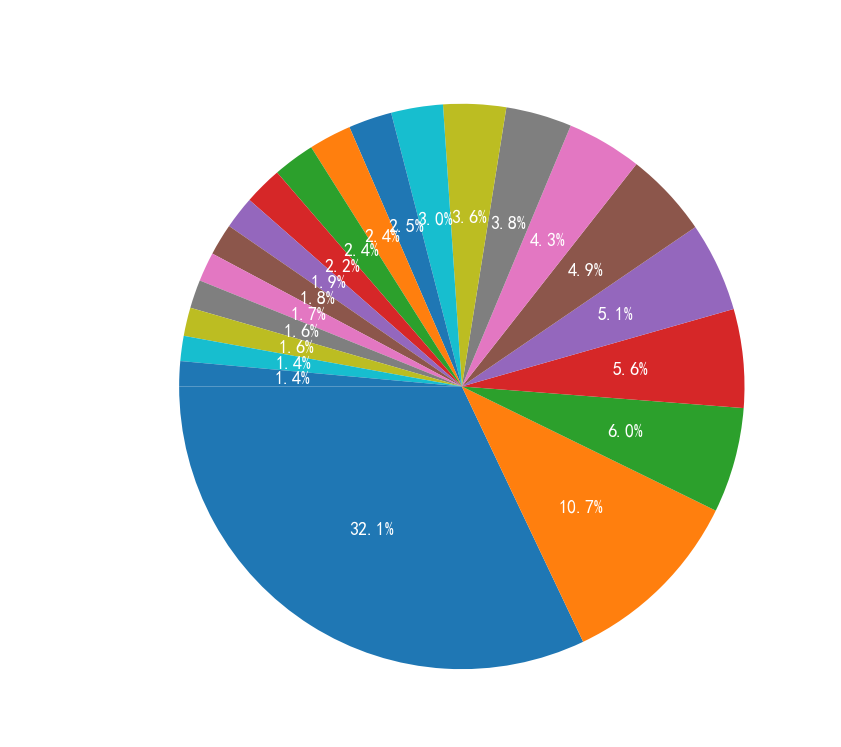

In [8]:
TagsSeries = videosDatabaseDF['videoTag'].value_counts()
TagsLength = len(TagsSeries)
# print(TagsSeries.to_string())
# print(TagsSeries.sort_values)

print("标签总数 : ", TagsLength)
TagDict = {}
TagDict['其他'] = 0

for tag_idx in range(TagsLength):
    tagName = TagsSeries.index[tag_idx]
    tagAmount = TagsSeries.iloc[tag_idx]
    if tag_idx < 20:
        TagDict[tagName] = tagAmount
    else:
        TagDict['其他'] += tagAmount

print(TagDict)
print(SeparateBar)


plt.figure(figsize=(13,13))
textProps = {"fontsize":18, "color":"w"}
plt.title("上榜视频标签分析饼图", fontdict={"fontsize":25, "color":"w"})
plt.pie(TagDict.values(), labels=TagDict.keys(), autopct="%1.1f%%", textprops=textProps, shadow=False, startangle=180);

### 视频标题及推荐理由高频词分析

In [12]:
VideoTitleSeries = videosDatabaseDF.loc[:,'videoName']
VideoRecommendReasonSeries = videosDatabaseDF.loc[:, 'videoRecommendReason']

# 将各个标题进行组合
joinedTitle = ' '.join(str(title) for title in VideoTitleSeries)
joinedRecommend = ' '.join(str(reason) for reason in VideoRecommendReasonSeries)

titleKeywords = jieba.analyse.extract_tags(joinedTitle, withWeight=True, topK=100)
recommendKeywords = jieba.analyse.extract_tags(joinedRecommend, withWeight=True, topK=100)

# print(titleKeywords)
# print(recommendKeywords)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\35058\AppData\Local\Temp\jieba.cache
Loading model cost 0.613 seconds.
Prefix dict has been built successfully.


In [13]:
def getWordCloud(imagePath, pltTitle, keywordsListWithFreq, recolor):
    backgroundImage = np.array(Image.open(imagePath))
    imageColors = wordcloud.ImageColorGenerator(backgroundImage)

    keywordsDictWithFreq = {}
    for oneTuple in keywordsListWithFreq:
        keywordsDictWithFreq[oneTuple[0]] = oneTuple[1]

    fontPath = r'c:\Windows\Fonts\simfang.ttf'

    WordCloud = wordcloud.WordCloud(mask=backgroundImage, background_color="white", width=698, height=698, font_path=fontPath)
    WordCloudPic = WordCloud.generate_from_frequencies(keywordsDictWithFreq)

    plt.figure(figsize=(20,40))

    plt.subplot(1,2,1)
    plt.title(pltTitle)
    if recolor is True:
        WordCloudPic = WordCloudPic.recolor(color_func=imageColors)
    plt.imshow(WordCloudPic)

    plt.subplot(1,2,2)
    plt.title("模板原图")
    plt.imshow(backgroundImage)


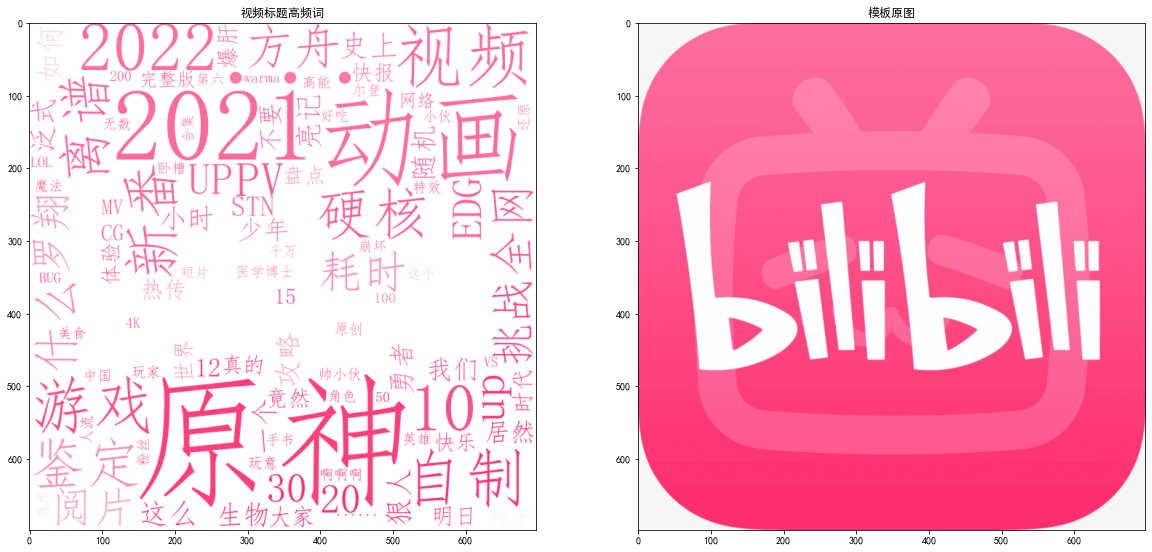

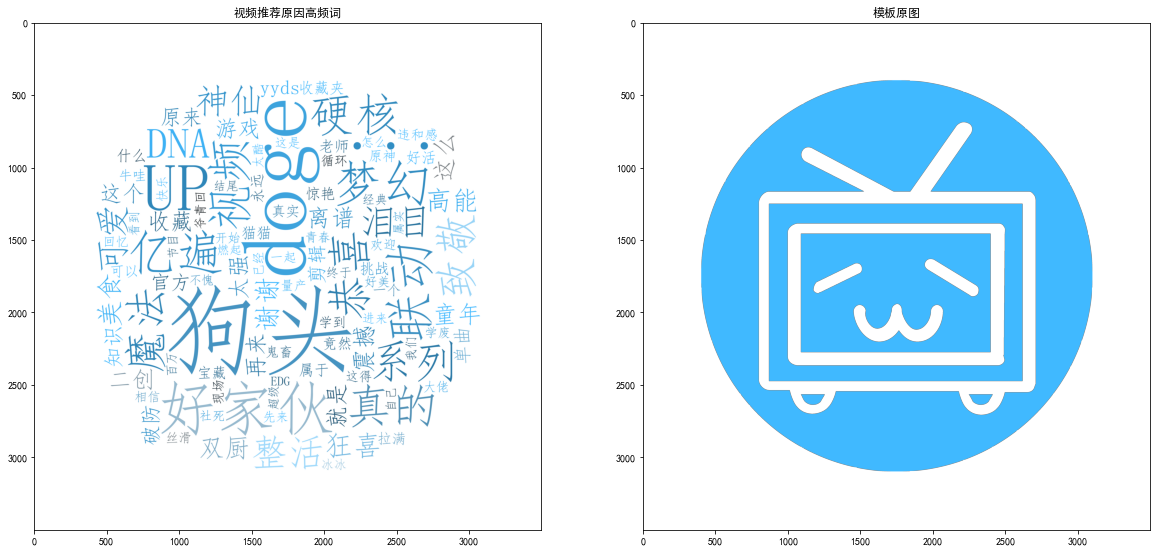

In [14]:
getWordCloud(r'ipynbPics\pink_tv.png', "视频标题高频词", titleKeywords, True)
getWordCloud(r'ipynbPics\blue_tv.png', "视频推荐原因高频词", recommendKeywords, True)

### 展示数据波动

In [45]:
careBoardVideosInfoNames = ['videoBoardID', 'videoViews', 'videoDanmaku', 'videoLength', 'videoLikes', 'videoCoins', 'videoFavorites', 'videoComments', 'videoShares']
boardVideosAverageInfo = videosDatabaseDF[careBoardVideosInfoNames].groupby('videoBoardID').max()

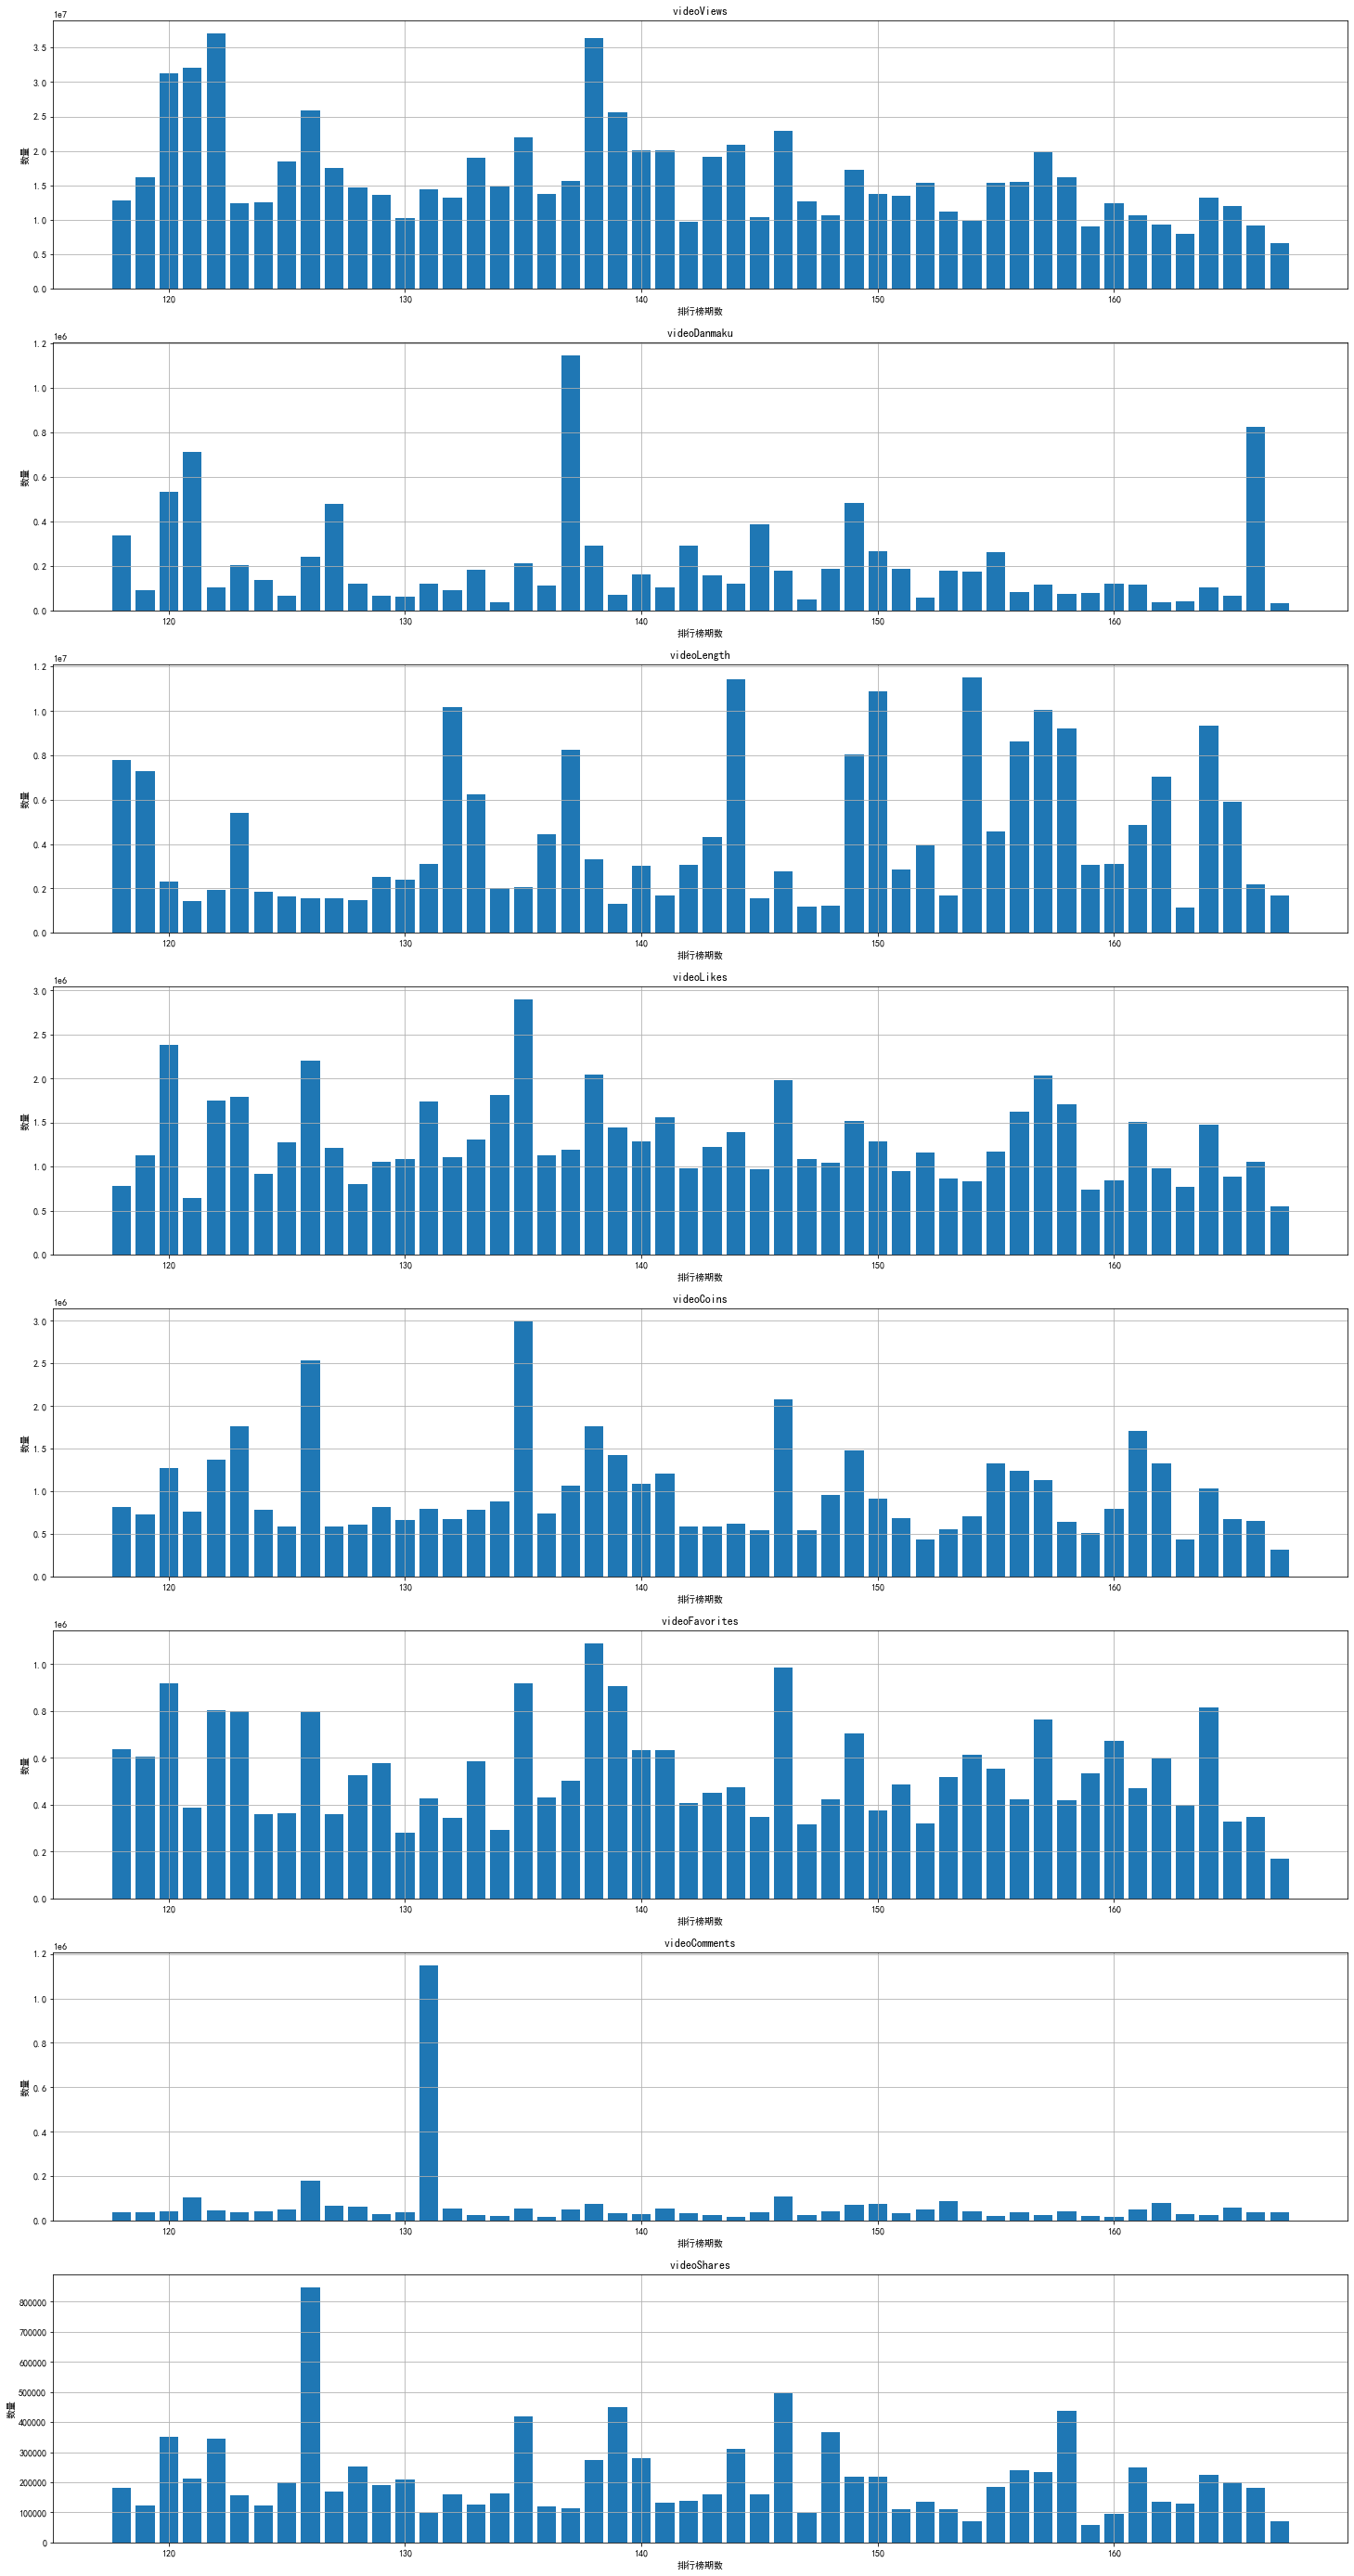

In [46]:
plt.figure(figsize=(25,50))
InfoNumbers = boardVideosAverageInfo.shape[1]
for infoIdx, infoName in enumerate(careBoardVideosInfoNames[1:]):
    tempInfoDict = boardVideosAverageInfo[infoName].to_dict()
    # print(tempInfoDict)
    plt.subplot(InfoNumbers, 1, infoIdx+1)
    plt.title(infoName)
    plt.xlabel("排行榜期数")
    plt.ylabel("数量")
    plt.grid()
    plt.bar(x=tempInfoDict.keys(), height=tempInfoDict.values()) # 设置颜色及透明度





    

### B站视频相关性指标关联性分析

<AxesSubplot:>

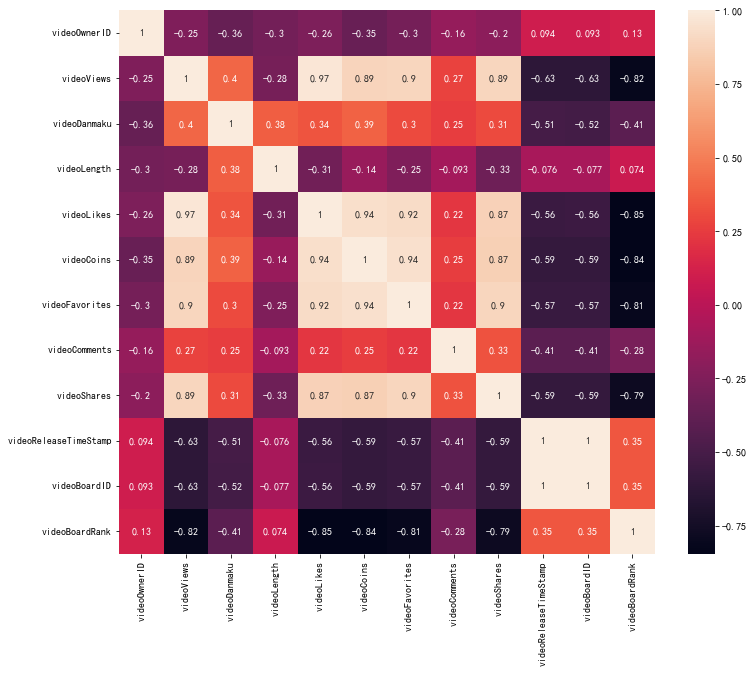

In [44]:
correlationMatrix = videosDatabaseDF.corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlationMatrix.corr(), annot=True)

由相关性矩阵可以看出，一个视频的点赞量、投币量、收藏量、转发量、观看量这几个指标在B站平台都是强相关的。
同时视频的受欢迎程度和视频的时长呈负相关，这说明人民普遍更喜欢看时长较短的视频，也更愿意去点赞和

### up主评选

最高产up Top20

In [78]:
hardestUserDF = usersDatabaseDF[['userName', 'userVideos']].groupby('userName').max()
hardestUserDF = hardestUserDF.sort_values(ascending=False, by='userVideos')[0:20]
print(type(hardestUserDF))
hardestUserDF

<class 'pandas.core.frame.DataFrame'>


,userVideos
userName,
star星视频,31173
央视网,16300
观察者网,13165
中国日报,7237
央视新闻,4585
四川观察,4532
哔哩哔哩英雄联盟赛事,4019
共青团中央,3810
央视频,3609


粉丝数最多up主 Top20

In [79]:
popularUserDF = usersDatabaseDF[['userName', 'userFans']].groupby('userName').max()
popularUserDF = popularUserDF.sort_values(ascending=False, by='userFans')[0:20]
print(type(popularUserDF))
popularUserDF

<class 'pandas.core.frame.DataFrame'>


,userFans
userName,
罗翔说刑法,22736797
老番茄,17268968
哔哩哔哩英雄联盟赛事,11566510
原神,11554915
共青团中央,9581901
绵羊料理,9553728
老师好我叫何同学,9496558
央视新闻,9326856
敬汉卿,9282411


### 视频评选

观看次数最多 Top20

In [83]:
mostViewsDF = videosDatabaseDF[['videoName', 'videoBoardID','videoViews']].sort_values(by='videoViews', ascending=False)[0:20]
mostViewsDF

,videoName,videoBoardID,videoViews
1906,⚡萨 日 朗！！！⚡,122,37104185
1299,《孤勇者》（《英雄联盟：双城之战》动画剧集中文主题曲）,138,36340242
1946,【时代少年团】「五月粉丝见面会实况」-《世界上的另一个我》纯享版,121,32033332
1976,破亿纪念!【猛男版】新宝岛 4K高清重置加强版,120,31296464
1748,人类高质量玩具！我蚌埠住了，哈哈哈哈哈哈,126,25900519
1248,前方高能！《孤勇者》女声版 超A燃炸！！,139,25620104
1747,《黑神话：悟空》12分钟UE5实机测试集锦,126,25033560
1751,不是吧不是吧，别人发都火了，我自己发还能火吗？,126,23941129
950,《原神》剧情PV-「神女劈观」,146,22974335
1401,【何同学】我做了苹果放弃的产品...,135,22004589


弹幕数量最多 Top20

In [85]:
mostDanmakuDF = videosDatabaseDF[['videoName', 'videoBoardID','videoDanmaku']].sort_values(by='videoDanmaku', ascending=False)[0:20]
mostDanmakuDF

,videoName,videoBoardID,videoDanmaku
1340,【时代少年团】《光环中的少年——“踯躅”》,137,1147328
52,【时代少年团】《循梦》,166,824367
1946,【时代少年团】「五月粉丝见面会实况」-《世界上的另一个我》纯享版,121,710589
1991,【时代少年团】「火力全开」五月粉丝见面会练习室联排,120,531826
835,？,149,482530
1711,第一次打完球有女生加我微信，结果啊啊啊啊啊啊啊啊啊,127,478942
997,在2022年之前看完这个视频！(看简介),145,389152
2087,【Henry刘宪华】With Ailee《Rolling in the Deep》,118,339598
802,2022原神新春会,149,331535
1128,【时代少年团】《这福气给你要不要》之福气大秀筹备中,142,293460


视频长度最长 Top20

In [86]:
longestVideoDF = videosDatabaseDF[['videoName', 'videoBoardID','videoLength']].sort_values(by='videoLength', ascending=False)[0:20]
longestVideoDF

,videoName,videoBoardID,videoLength
575,一口气看完《寂静岭》系列剧情！救赎之道，就在其中！,154,11532431
1027,超凡蜘蛛侠3应该是这样拍的！(游戏电影)《漫威/超凡蜘蛛侠3-战导剪辑版》,144,11421369
754,2022哔哩哔哩拜年纪,150,10905665
1550,将DNF剪成一部电影会发生什么？时长2小时50分存活确认！你能坚持看完吗？一口气看个爽！,132,10193467
455,【王老菊】环王立后传 | 艾尔登法环EP.12,157,10049167
155,B站独家《刺客信条 : 大革命》电影版 含全新镜头 中法英三字 155分钟完整版 激荡的革命...,164,9348333
383,火影中那些无法超越的画面与台词,158,9201549
493,【王老菊】你被撵着跑的样子像极了一条狗 | 艾尔登法环EP.08,156,8630457
1340,【时代少年团】《光环中的少年——“踯躅”》,137,8244451
814,2022明日方舟新春会「流光启明」-上,149,8032207


点赞次数最多 Top20

In [89]:
mostLikesDF = videosDatabaseDF[['videoName', 'videoBoardID','videoLikes']].sort_values(by='videoLikes', ascending=False)[0:20]
mostLikesDF

,videoName,videoBoardID,videoLikes
1401,【何同学】我做了苹果放弃的产品...,135,2902459
1976,破亿纪念!【猛男版】新宝岛 4K高清重置加强版,120,2380736
1747,《黑神话：悟空》12分钟UE5实机测试集锦,126,2198890
1273,史上最离谱随机挑战！我们终于去老番茄家蹭饭了！！【第七期】,138,2044465
420,⚡️ 中 国 人 不 蹦 洋 迪 ⚡️,157,2039258
932,特效炸裂！年度之战！特效小哥大战建模小哥4,146,1984643
1299,《孤勇者》（《英雄联盟：双城之战》动画剧集中文主题曲）,138,1837001
1439,说出来你们可能不信，我差点被这个小姑娘难住了,134,1807566
1870,【何同学】永远是同学,123,1791443
1906,⚡萨 日 朗！！！⚡,122,1754655


投币数量最多 Top20

In [90]:
mostCoinsDF = videosDatabaseDF[['videoName', 'videoBoardID','videoCoins']].sort_values(by='videoCoins', ascending=False)[0:20]
mostCoinsDF

,videoName,videoBoardID,videoCoins
1401,【何同学】我做了苹果放弃的产品...,135,2997729
1747,《黑神话：悟空》12分钟UE5实机测试集锦,126,2532222
1749,【才浅手工】花费4个月25万元探寻三星堆金杖制作工艺之谜,126,2204687
932,特效炸裂！年度之战！特效小哥大战建模小哥4,146,2076467
950,《原神》剧情PV-「神女劈观」,146,2036361
1870,【何同学】永远是同学,123,1764598
1299,《孤勇者》（《英雄联盟：双城之战》动画剧集中文主题曲）,138,1760215
238,【何同学】我找到了我最喜欢的数码产品，但是...,161,1713871
802,2022原神新春会,149,1479942
1248,前方高能！《孤勇者》女声版 超A燃炸！！,139,1430990


收藏次数最多 Top20

In [91]:
mostFavoritesDF = videosDatabaseDF[['videoName', 'videoBoardID','videoFavorites']].sort_values(by='videoFavorites', ascending=False)[0:20]
mostFavoritesDF

,videoName,videoBoardID,videoFavorites
1299,《孤勇者》（《英雄联盟：双城之战》动画剧集中文主题曲）,138,1089468
950,《原神》剧情PV-「神女劈观」,146,986237
1993,【每天一遍】10分钟肚腩消减训练(男女通用),120,918491
1401,【何同学】我做了苹果放弃的产品...,135,916665
1248,前方高能！《孤勇者》女声版 超A燃炸！！,139,905637
130,“历史书太小 装不下一个人波澜壮阔的一生 历史书又太大 装下了华夏上下五千年 ”,164,814640
1906,⚡萨 日 朗！！！⚡,122,801082
1885,这些学生党最应该知道的事！可惜之前没人告诉我…技能/软件/编程/英语/二外/计算机二级/其他...,123,798420
1747,《黑神话：悟空》12分钟UE5实机测试集锦,126,794874
1976,破亿纪念!【猛男版】新宝岛 4K高清重置加强版,120,767968


评论次数最多 Top20

In [92]:
mostCommentsDF = videosDatabaseDF[['videoName', 'videoBoardID','videoComments']].sort_values(by='videoComments', ascending=False)[0:20]
mostCommentsDF

,videoName,videoBoardID,videoComments
1589,【A-SOUL/贝&珈&嘉】太潮啦！师徒三人演绎《隔岸 (DJ)》,131,1150163
1747,《黑神话：悟空》12分钟UE5实机测试集锦,126,177434
950,《原神》剧情PV-「神女劈观」,146,106325
1949,《崩坏3》动画短片「薪炎永燃」,121,104543
1946,【时代少年团】「五月粉丝见面会实况」-《世界上的另一个我》纯享版,121,96960
618,【时代少年团】宋亚轩刘耀文《一起等雨停》,153,88988
218,个人单曲《Wandering Singer》完整版MV,162,80922
775,【2022·东方华灯宴】,150,75807
1299,《孤勇者》（《英雄联盟：双城之战》动画剧集中文主题曲）,138,74009
811,《崩坏3》动画短片「阿波卡利斯如是说」,149,69510


转发次数最多 Top20

In [93]:
mostSharesDF = videosDatabaseDF[['videoName', 'videoBoardID','videoShares']].sort_values(by='videoShares', ascending=False)[0:20]
mostSharesDF

,videoName,videoBoardID,videoShares
1747,《黑神话：悟空》12分钟UE5实机测试集锦,126,848552
950,《原神》剧情PV-「神女劈观」,146,494966
1232,反 向 带 货,139,450906
390,【舔狗之王】“我最巅峰的时候同时舔七个”,158,437036
1401,【何同学】我做了苹果放弃的产品...,135,419865
854,出来混，总是要胖的！,148,365197
1976,破亿纪念!【猛男版】新宝岛 4K高清重置加强版,120,351982
1906,⚡萨 日 朗！！！⚡,122,343773
1024,“总有一天，全城的狗，都要高看我！”,144,312157
1750,【广场往事】《妇仇者联盟》：枪在手，跟鹅走！,126,311093
